In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

def default_palette_for_labels(labels):
    colors = sns.color_palette("deep", n_colors=len(labels))
    return dict(zip(labels, colors))

# Consistent color mapping
labels = ["default", "scalable","pyattimo (delta=0.25, v=0.6.4)", 
          "pyattimo (delta=0.5, v=0.6.4)", "pyattimo (v=0.6.4)"]



def plot_df(df, ds_name, l=125, k=20):
    palette = default_palette_for_labels(labels)

    df.reset_index(inplace=True)
    indices = df[df.backend == "scalable"].length
    df = df[df.length.isin(indices)]
    
    df = df.sort_values(['length', 'backend'], ascending=[True, True]).reset_index()  #drop=True    
    df_normed = df.reset_index().groupby(["length"]).apply(
        lambda l: l["extent"] * 100 / (l[l["backend"]=="scalable"]["extent"].iloc[-1])).reset_index()
    
    # df_normed.set_index("length").head()
    df["extent_normed"] = df_normed["extent"]
        
    df["memory in GB"] = df["memory in MB"] / 1024
    df.set_index("length", inplace=True, drop=True)
    df = df.sort_values(by="backend") 

    # display(df)
    # df.index = df.index*2
    
    mask = df.backend=="default"
    subset = df[mask] 
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    
    sns.lineplot(x=df.index, hue=df.backend, y=df["time in s"], ax=axes[0], palette=palette)
    axes[0].set_title("Time in s", fontsize=18)
    axes[0].tick_params(axis='x', labelrotation=-25)
    axes[0].set_xlabel("Length n")    
    # axes[0].set_yscale('log')
    plt.yticks(fontsize=10)
    plt.ylabel("Time in s")
    sns.despine()
    
    sns.lineplot(x=df.index, hue=df.backend, y=df["memory in GB"], ax=axes[1], palette=palette)
    axes[1].set_title("Memory", fontsize=18)
    axes[1].tick_params(axis='x', labelrotation=-25)
    axes[1].set_xlabel("Length n")
    axes[1].set_ylabel("Memory in GB")
    # axes[1].set_yscale('log')
    plt.yticks(fontsize=10)
    sns.despine()
    
    
    df_filter = df[df['backend'].str.contains("pyattimo")]
    sns.lineplot(x=df_filter.index, hue=df_filter.backend, y=df_filter["extent_normed"], ax=axes[2], palette=palette)
    # sns.lineplot(x=df.index, hue=df.backend, y=df["extent"], ax=axes[2], palette=palette)
    axes[2].set_title("Extent as fraction of 'scalable'", fontsize=18)
    axes[2].tick_params(axis='x', labelrotation=-35)
    axes[2].set_xlabel("Length n")
    axes[2].set_ylabel("Extent (100% = scalable)")
    # axes[2].set_ylim(70, 200)
    axes[2].axhline(y=100, color='r', linestyle='--', label="scalable")

    axes[2].annotate(
        'Scalable = 100%',             # Text to display
        xy=(df.index.min(), 100),          # Point to annotate (x, y)
        fontsize=10         # Font size (optional)
    )
    
    plt.yticks(fontsize=10)
    sns.despine()
    
    plt.suptitle(f"Scalability for {ds_name} l={l}, k={k} using 64 cores", fontsize=20)
    plt.tight_layout()
    # plt.savefig(f"../tests/results/images/scalability_n_{ds_name}_{l}_{k}.pdf")
    plt.show()

    df["dataset"] = ds_name
    return df


backends=["default", "scalable", "pyattimo (delta=0.25, v=0.6.4)", "pyattimo (delta=0.5, v=0.6.4)"]
subdirs = ["default", "delta_logs_v0.6.2", "delta_logs_v0.6.4", "subsample_logs"]
path = "../tests/results/scalability_experiments/"

# Penguin 1m

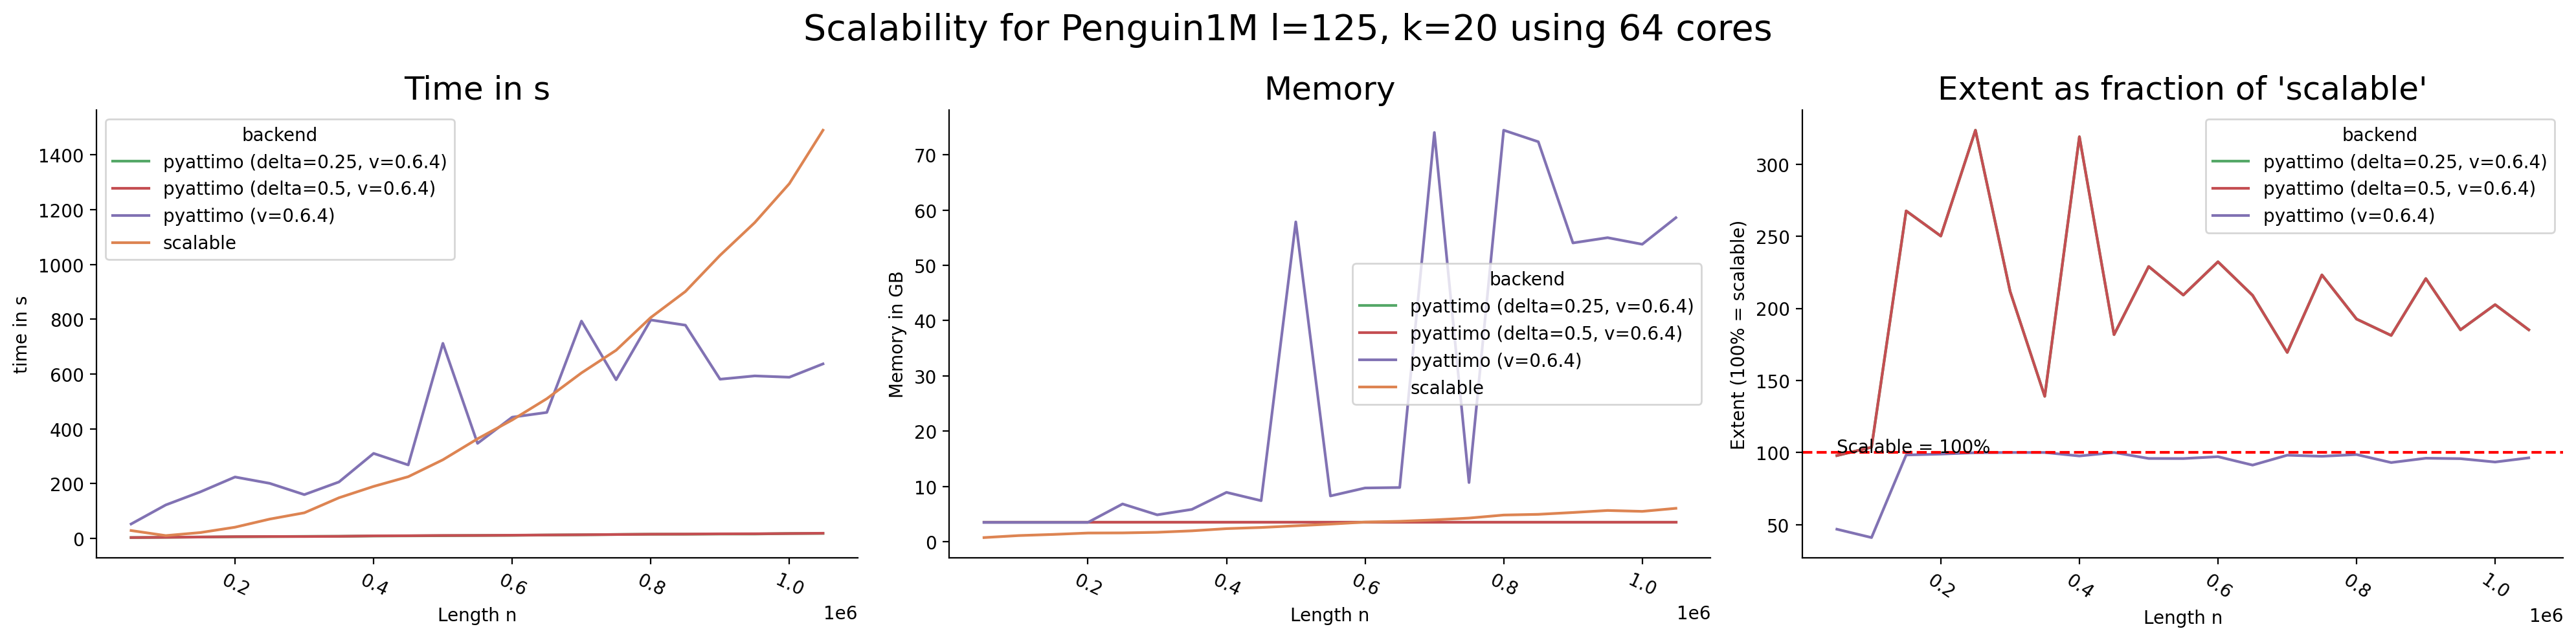

In [2]:
def read_penguin1m():
    filename = "scalability_n_penguin1M_125_10"
    
    df = pd.read_csv(path + "default/" + filename + ".csv", index_col=0)    
    for backend in ["delta_logs_v0.6.4"]:   # "delta_logs_v0.6.2", 
        df_delta_0_25 = pd.read_csv(path + backend + "/" + filename + "_delta_0.25.csv", index_col=0)
        # df_delta_0_25["backend"] = df_delta_0_25["backend"].astype(str)
        df_delta_0_50 = pd.read_csv(path + backend + "/" + filename + "_delta_0.5.csv", index_col=0)
        # df_delta_0_50["backend"] = df_delta_0_50["backend"].astype(str)
        df_no_delta = pd.read_csv(path + backend + "/" + filename + ".csv", index_col=0)
        # df_no_delta["backend"] = df_no_delta["backend"].astype(str)
        df = pd.concat([df, df_delta_0_25, df_delta_0_50, df_no_delta], ignore_index=False)
    
    return "Penguin1M", df
    
ds_name, df = read_penguin1m()
backends = ["scalable", "pyattimo (v=0.6.4)", "pyattimo (delta=0.25, v=0.6.4)", "pyattimo (delta=0.5, v=0.6.4)"]
df_sub = df[df.backend.isin(backends)]
df = plot_df(df, ds_name, l=125, k=20)


#backends = ["scalable", "pyattimo (delta=0.25) v0.6.2", "pyattimo (delta=0.5) v0.6.2"]
#df_sub = df[df.backend.isin(backends)]
#plot_df(df_sub, ds_name, l=125, k=20)

#backends = ["scalable", "pyattimo (delta=0.25) v0.6.4", "pyattimo (delta=0.5) v0.6.4"]
#df_sub = df[df.backend.isin(backends)]
#plot_df(df_sub, ds_name, l=125, k=10)

#backends = ["scalable", "pyattimo (delta=0.5) v0.6.2", "pyattimo (delta=0.5) v0.6.4"]
#df_sub = df[df.backend.isin(backends)]
#plot_df(df_sub, ds_name, l=125, k=20)

df_all = df

# Penguin 3m

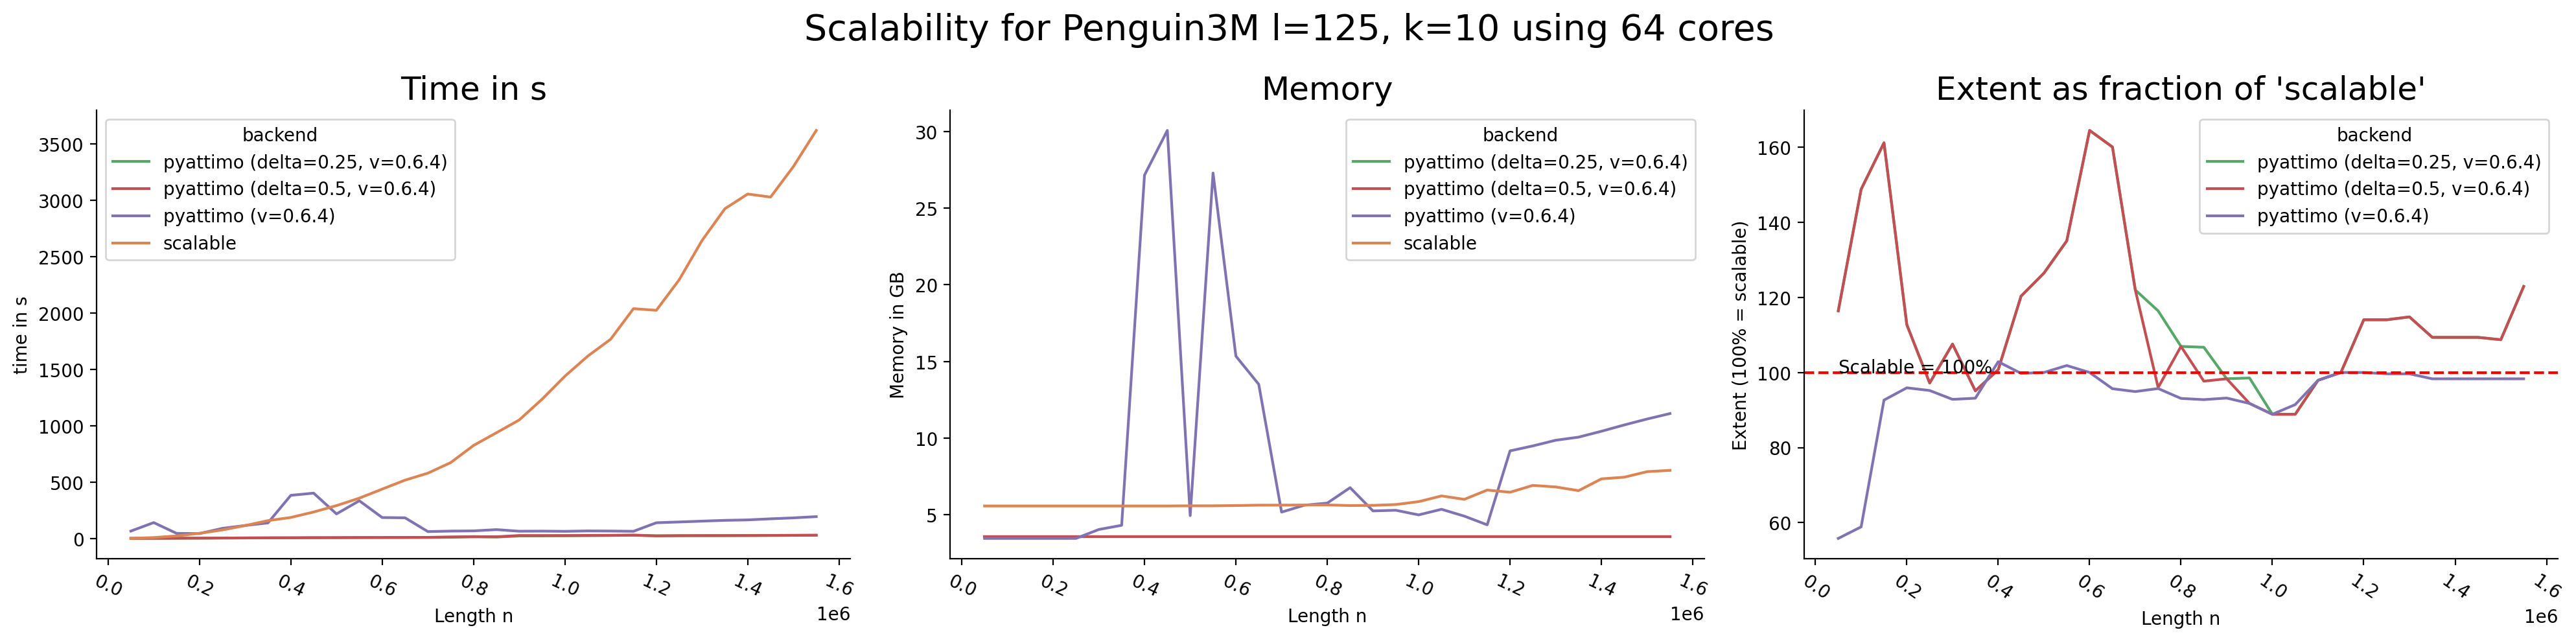

In [3]:
def read_penguin3m():
    # return "Penguin3M", pd.read_csv("../tests/results/scalability_n_penguin3m_125_20.csv", index_col=0)

    filename = "scalability_n_penguin3m_125_10"
    
    df = pd.read_csv(path + "default/" + filename + ".csv", index_col=0)
    for backend in ["delta_logs_v0.6.4"]:  # "delta_logs_v0.6.2", 
        df_delta_0_25 = pd.read_csv(path + backend + "/" + filename + "_delta_0.25.csv", index_col=0)
        df_delta_0_25["backend"] = df_delta_0_25["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_delta_0_50 = pd.read_csv(path + backend + "/" + filename + "_delta_0.5.csv", index_col=0)
        df_delta_0_50["backend"] = df_delta_0_50["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_no_delta = pd.read_csv(path + backend + "/" + filename + ".csv", index_col=0)
        df_no_delta["backend"] = df_no_delta["backend"].astype(str)# + " " + backend.split("_")[-1]
        df = pd.concat([df, df_delta_0_25, df_delta_0_50, df_no_delta], ignore_index=False)


    return "Penguin3M", df

ds_name, df = read_penguin3m()
df = plot_df(df, ds_name, l=125, k=10)

df_all = pd.concat([df_all, df], ignore_index=False)

# PAMAP

In [4]:
def read_pamap():
    # return "PAMAP", pd.read_csv("../tests/results/scalability_n_PAMAP_200_10.csv", index_col=0)

    filename = "scalability_n_PAMAP_200_10"
    
    df = pd.read_csv(path + "default/" + filename + ".csv", index_col=0)
    for backend in ["delta_logs_v0.6.4"]:  # "delta_logs_v0.6.2", 
        df_delta_0_25 = pd.read_csv(path + backend + "/" + filename + "_delta_0.25.csv", index_col=0)
        df_delta_0_25["backend"] = df_delta_0_25["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_delta_0_50 = pd.read_csv(path + backend + "/" + filename + "_delta_0.5.csv", index_col=0)
        df_delta_0_50["backend"] = df_delta_0_50["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_no_delta = pd.read_csv(path + backend + "/" + filename + ".csv", index_col=0)
        df_no_delta["backend"] = df_no_delta["backend"].astype(str)# + " " + backend.split("_")[-1]
        df = pd.concat([df, df_delta_0_25, df_delta_0_50, df_no_delta], ignore_index=False)

    return "PAMAP", df
    
#ds_name, df = read_pamap()
#df = plot_df(df, ds_name, l=200, k=10)

#df_all = pd.concat([df_all, df], ignore_index=False)

# Arrhythmia

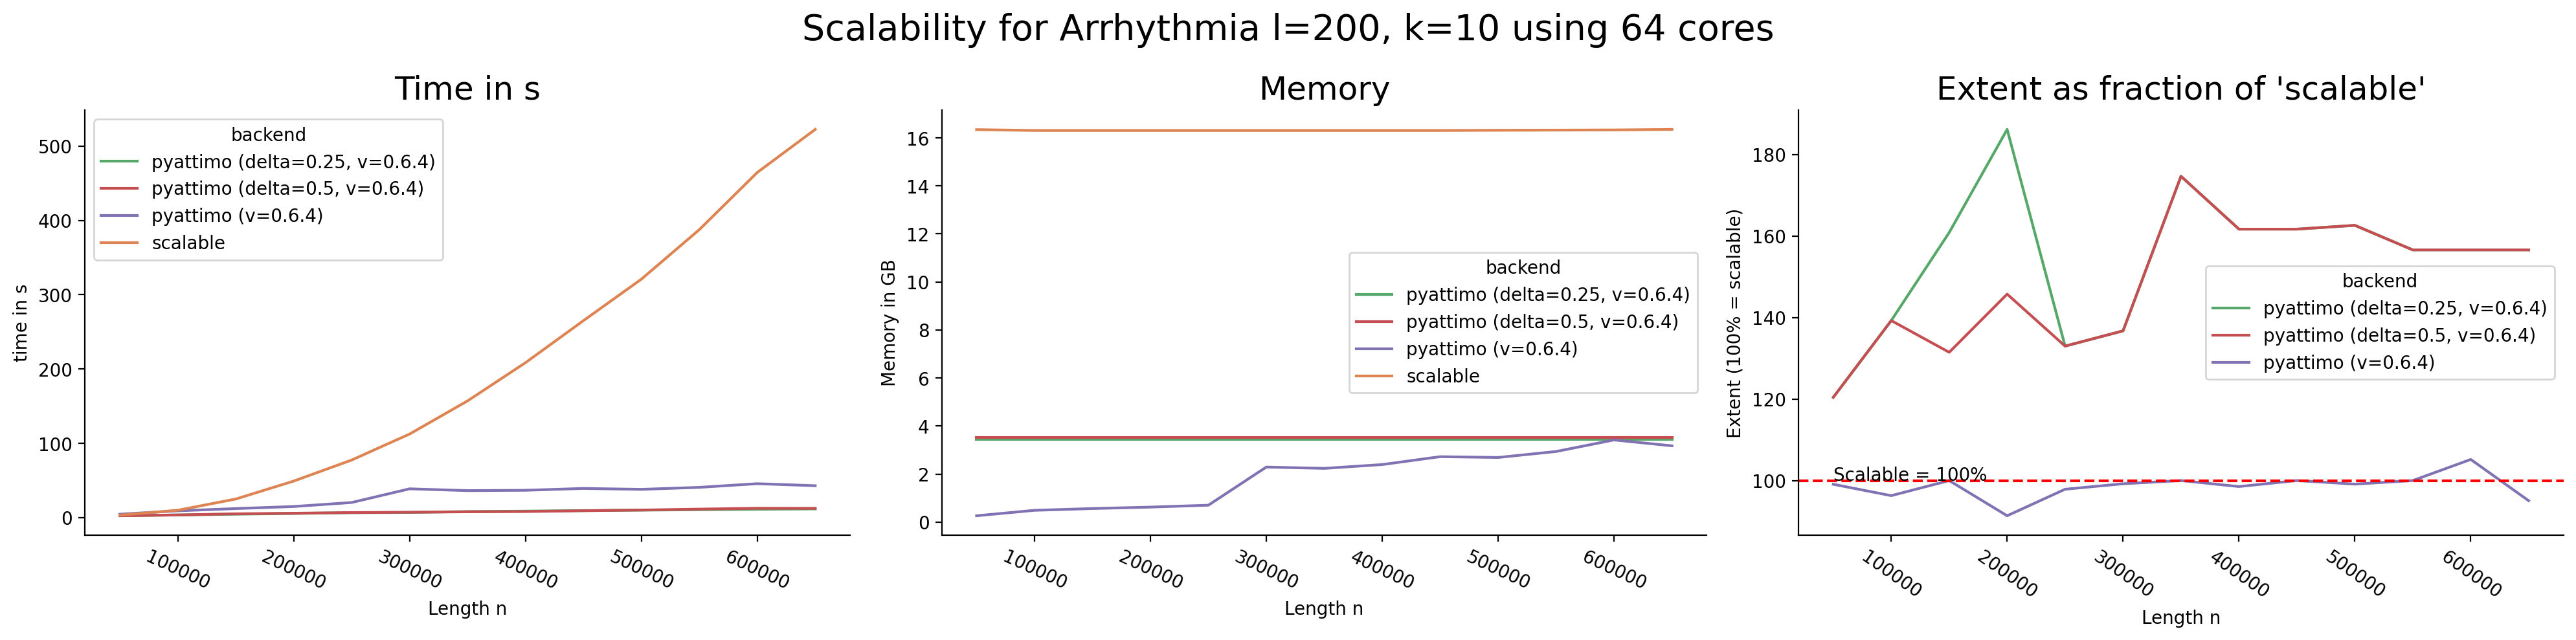

In [5]:
def read_arrhythmia():    
    filename = "scalability_n_Arrhythmia_200_10"
    
    df = pd.read_csv(path + "default/" + filename + ".csv", index_col=0)
    for backend in ["delta_logs_v0.6.4"]:  # "delta_logs_v0.6.2", 
        df_delta_0_25 = pd.read_csv(path + backend + "/" + filename + "_delta_0.25.csv", index_col=0)
        df_delta_0_25["backend"] = df_delta_0_25["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_delta_0_50 = pd.read_csv(path + backend + "/" + filename + "_delta_0.5.csv", index_col=0)
        df_delta_0_50["backend"] = df_delta_0_50["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_no_delta = pd.read_csv(path + backend + "/" + filename + ".csv", index_col=0)
        df_no_delta["backend"] = df_no_delta["backend"].astype(str)# + " " + backend.split("_")[-1]
        df = pd.concat([df, df_delta_0_25, df_delta_0_50, df_no_delta], ignore_index=False)

    return "Arrhythmia", df


ds_name, df = read_arrhythmia()
df = plot_df(df, ds_name, l=200, k=10)

df_all = pd.concat([df_all, df], ignore_index=False)

# EEG Sleep Data

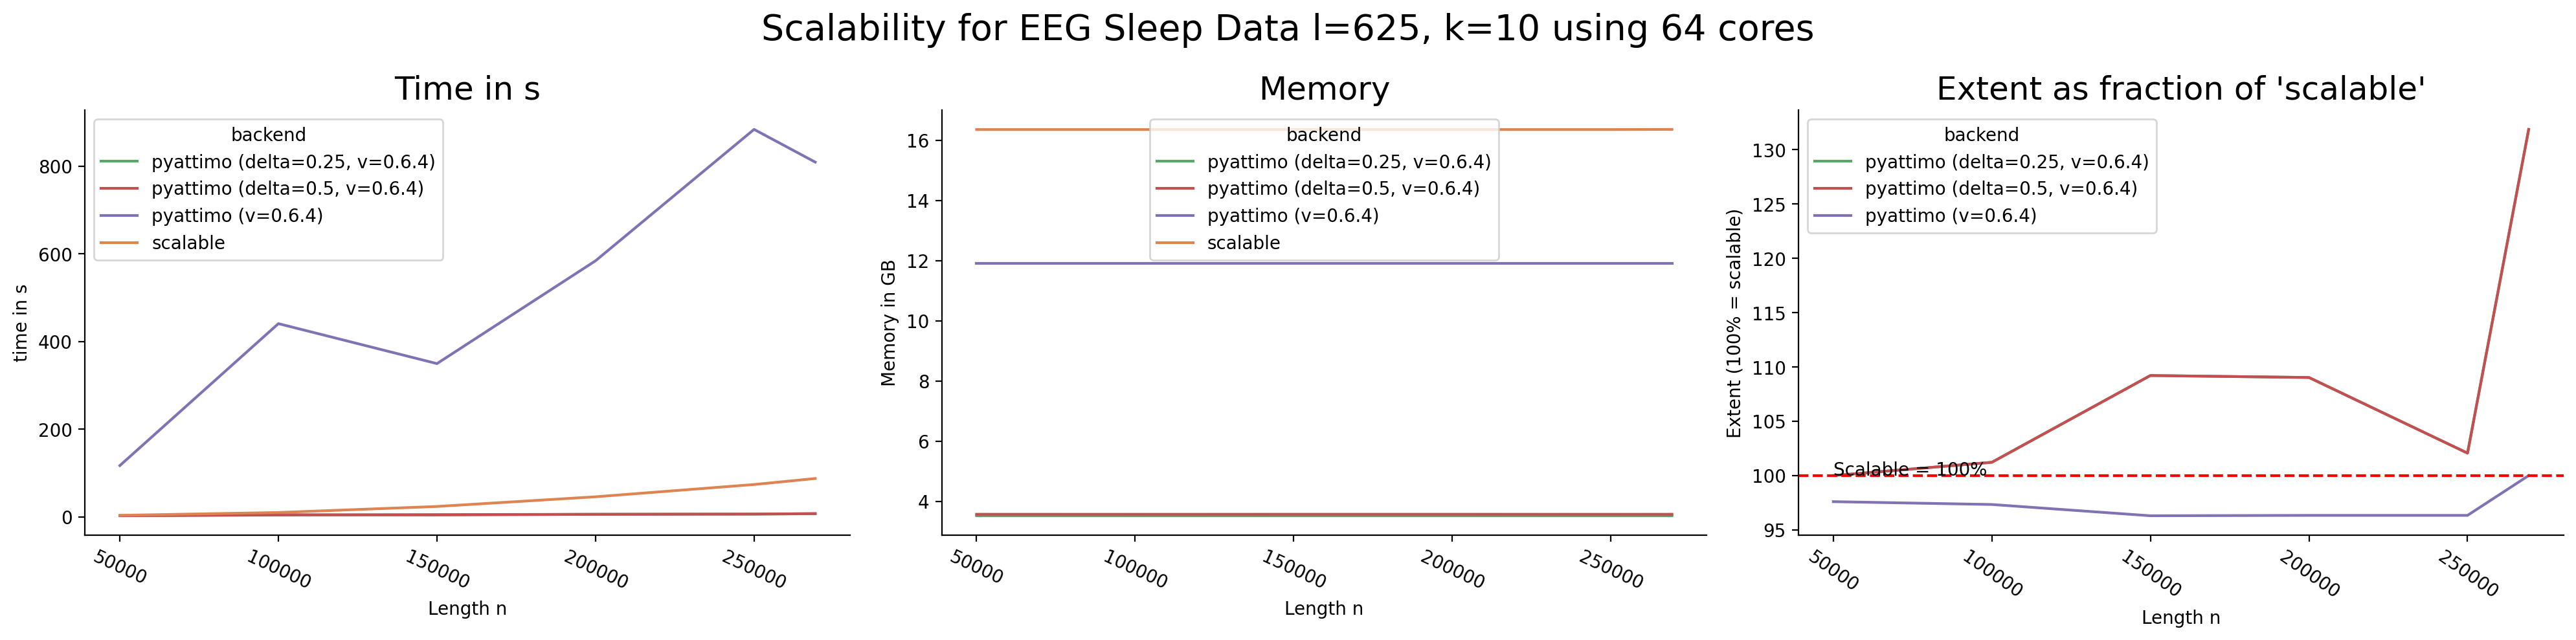

In [6]:
def read_EEG():
    # return "EEG Sleep Data", pd.read_csv("../tests/results/scalability_n_EEG-Sleep_625_20.csv", index_col=0)

    filename = "scalability_n_EEG-Sleep_625_10"
    
    df = pd.read_csv(path + "default/" + filename + ".csv", index_col=0)
    for backend in ["delta_logs_v0.6.4"]:  # "delta_logs_v0.6.2", 
        df_delta_0_25 = pd.read_csv(path + backend + "/" + filename + "_delta_0.25.csv", index_col=0)
        df_delta_0_25["backend"] = df_delta_0_25["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_delta_0_50 = pd.read_csv(path + backend + "/" + filename + "_delta_0.5.csv", index_col=0)
        df_delta_0_50["backend"] = df_delta_0_50["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_no_delta = pd.read_csv(path + backend + "/" + filename + ".csv", index_col=0)
        df_no_delta["backend"] = df_no_delta["backend"].astype(str)# + " " + backend.split("_")[-1]
        df = pd.concat([df, df_delta_0_25, df_delta_0_50, df_no_delta], ignore_index=False)

    return "EEG Sleep Data", df

ds_name, df = read_EEG()
df = plot_df(df, ds_name, l=625, k=10)

df_all = pd.concat([df_all, df], ignore_index=False)

# Dishwasher

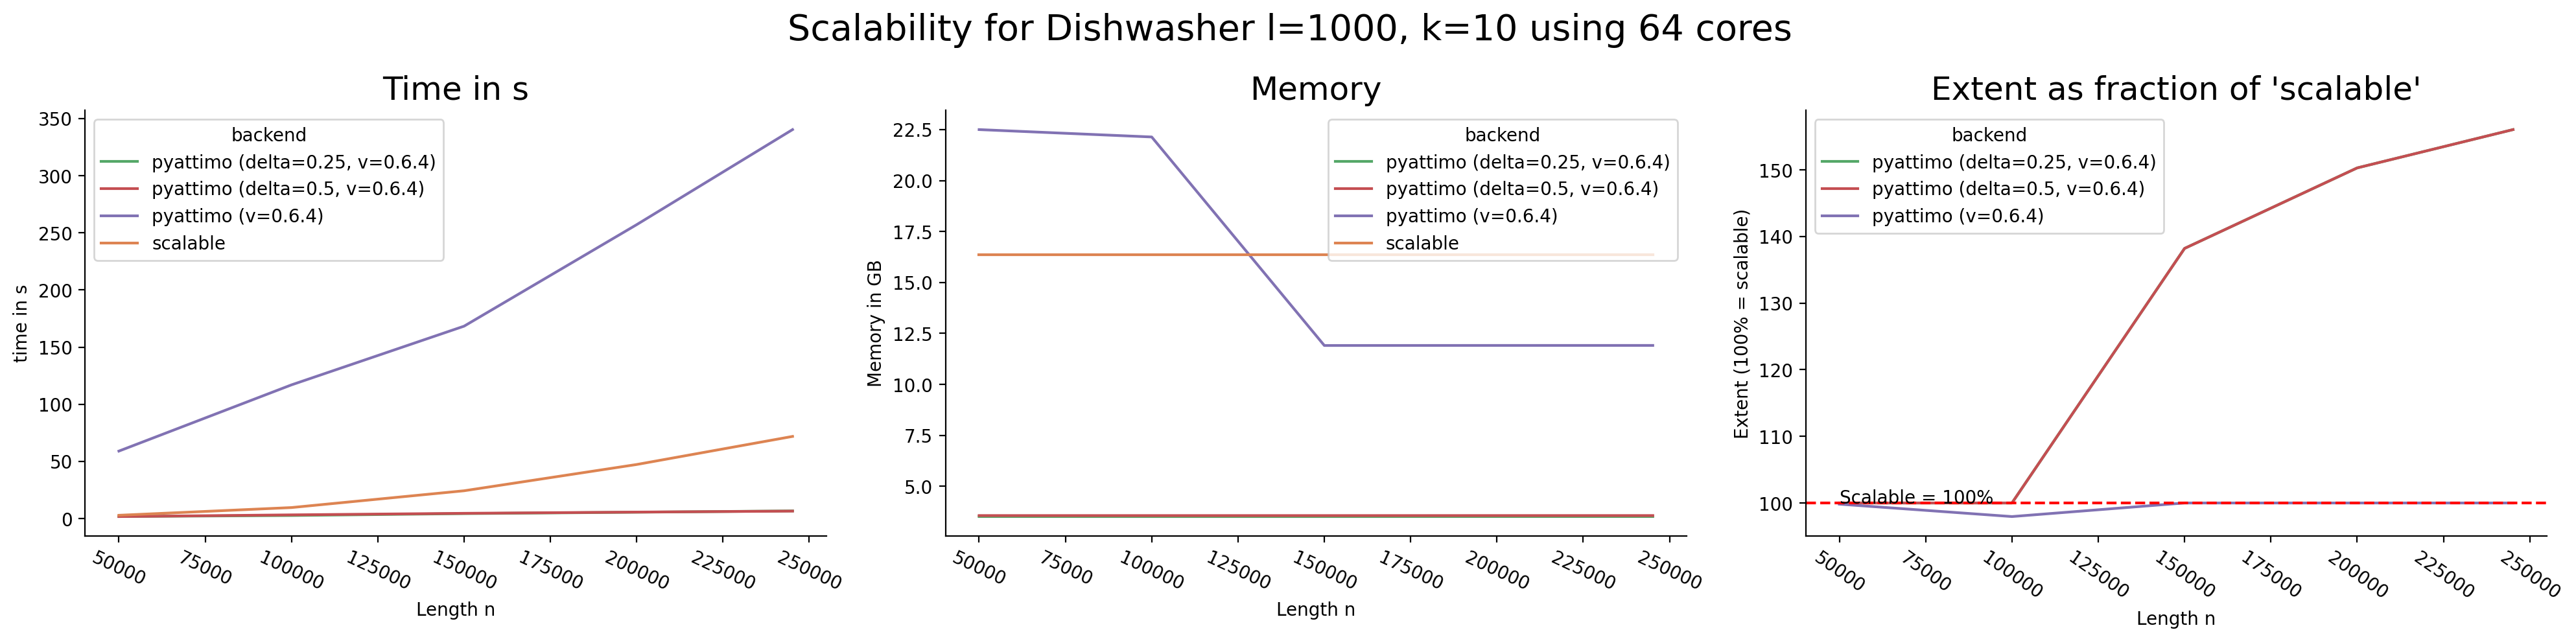

In [7]:
def read_dishwasher():
    # return "Dishwasher", pd.read_csv("../tests/results/scalability_n_Dishwasher_1000_20.csv", index_col=0)

    filename = "scalability_n_Dishwasher_1000_10"
    
    df = pd.read_csv(path + "default/" + filename + ".csv", index_col=0)
    for backend in ["delta_logs_v0.6.4"]:  # "delta_logs_v0.6.2", 
        df_delta_0_25 = pd.read_csv(path + backend + "/" + filename + "_delta_0.25.csv", index_col=0)
        df_delta_0_25["backend"] = df_delta_0_25["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_delta_0_50 = pd.read_csv(path + backend + "/" + filename + "_delta_0.5.csv", index_col=0)
        df_delta_0_50["backend"] = df_delta_0_50["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_no_delta = pd.read_csv(path + backend + "/" + filename + ".csv", index_col=0)
        df_no_delta["backend"] = df_no_delta["backend"].astype(str)# + " " + backend.split("_")[-1]
        df = pd.concat([df, df_delta_0_25, df_delta_0_50, df_no_delta], ignore_index=False)

    return "Dishwasher", df
    

ds_name, df = read_dishwasher()
df = plot_df(df, ds_name, l=1000, k=10)

df_all = pd.concat([df_all, df], ignore_index=False)

# GAP

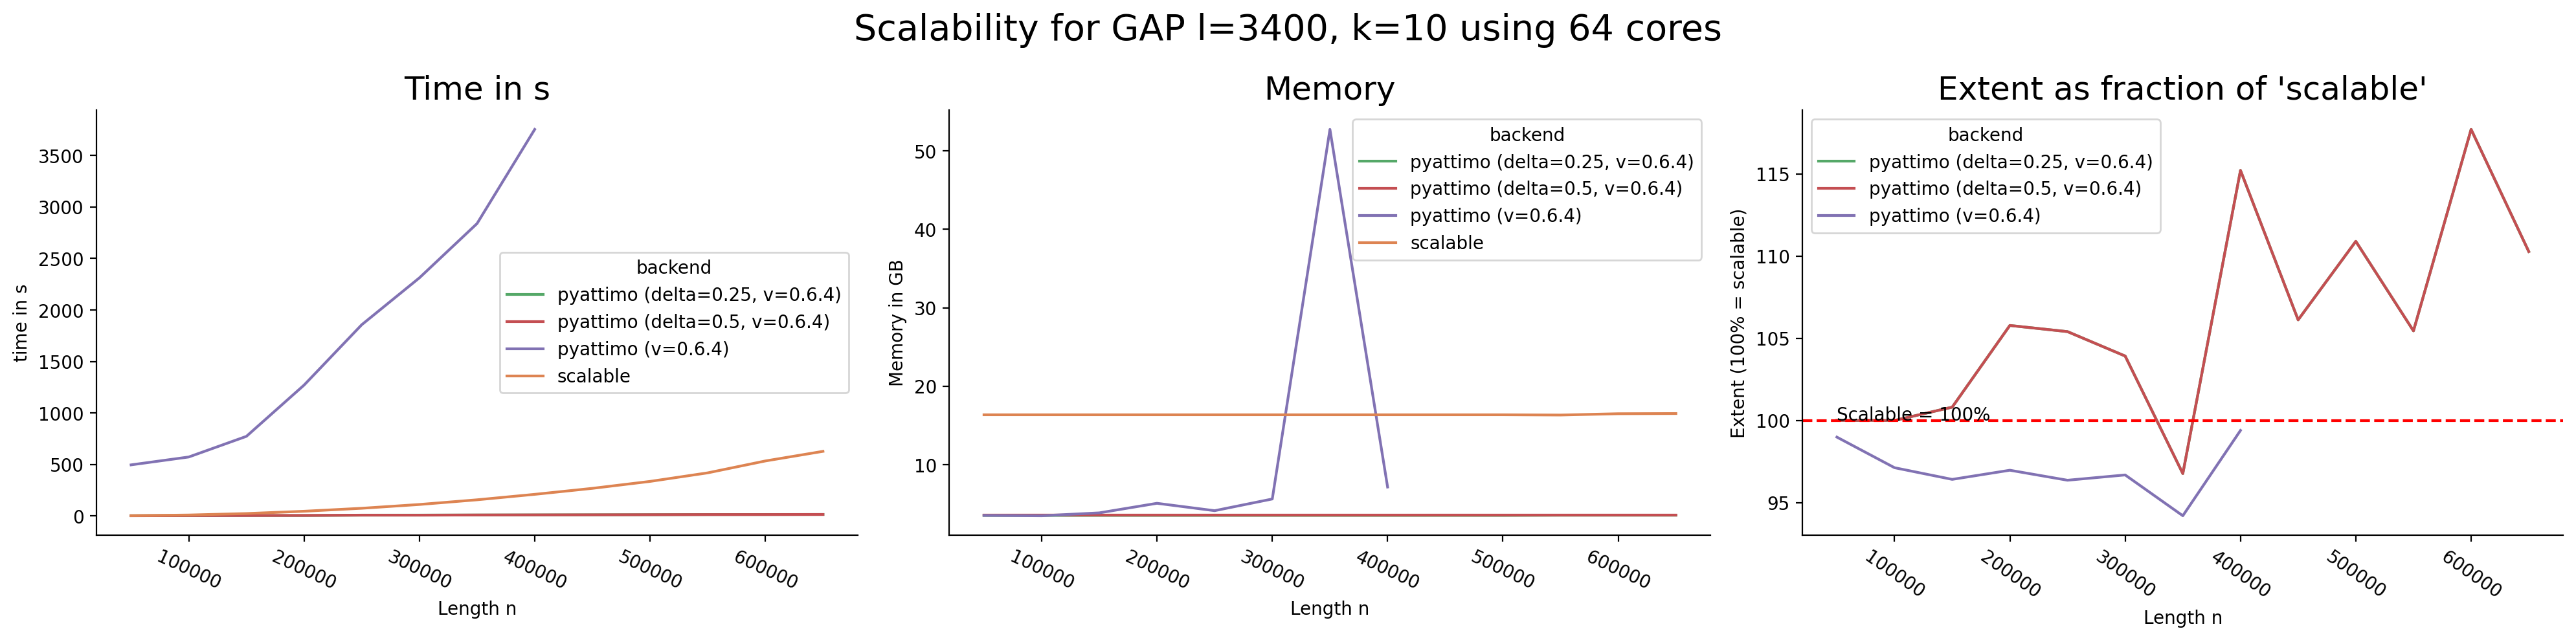

In [8]:
def read_gap():
    # return "GAP", pd.read_csv("../tests/results/scalability_n_GAP_3400_20.csv", index_col=0)

    filename = "scalability_n_GAP_3400_10"
    
    df = pd.read_csv(path + "default/" + filename + ".csv", index_col=0)
    for backend in ["delta_logs_v0.6.4"]:  # "delta_logs_v0.6.2", 
        df_delta_0_25 = pd.read_csv(path + backend + "/" + filename + "_delta_0.25.csv", index_col=0)
        df_delta_0_25["backend"] = df_delta_0_25["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_delta_0_50 = pd.read_csv(path + backend + "/" + filename + "_delta_0.5.csv", index_col=0)
        df_delta_0_50["backend"] = df_delta_0_50["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_no_delta = pd.read_csv(path + backend + "/" + filename + ".csv", index_col=0)
        df_no_delta["backend"] = df_no_delta["backend"].astype(str)# + " " + backend.split("_")[-1]
        df = pd.concat([df, df_delta_0_25, df_delta_0_50, df_no_delta], ignore_index=False)

    return "GAP", df

ds_name, df = read_gap()
df = plot_df(df, ds_name, l=3400, k=10)

df_all = pd.concat([df_all, df], ignore_index=False)

# Astro

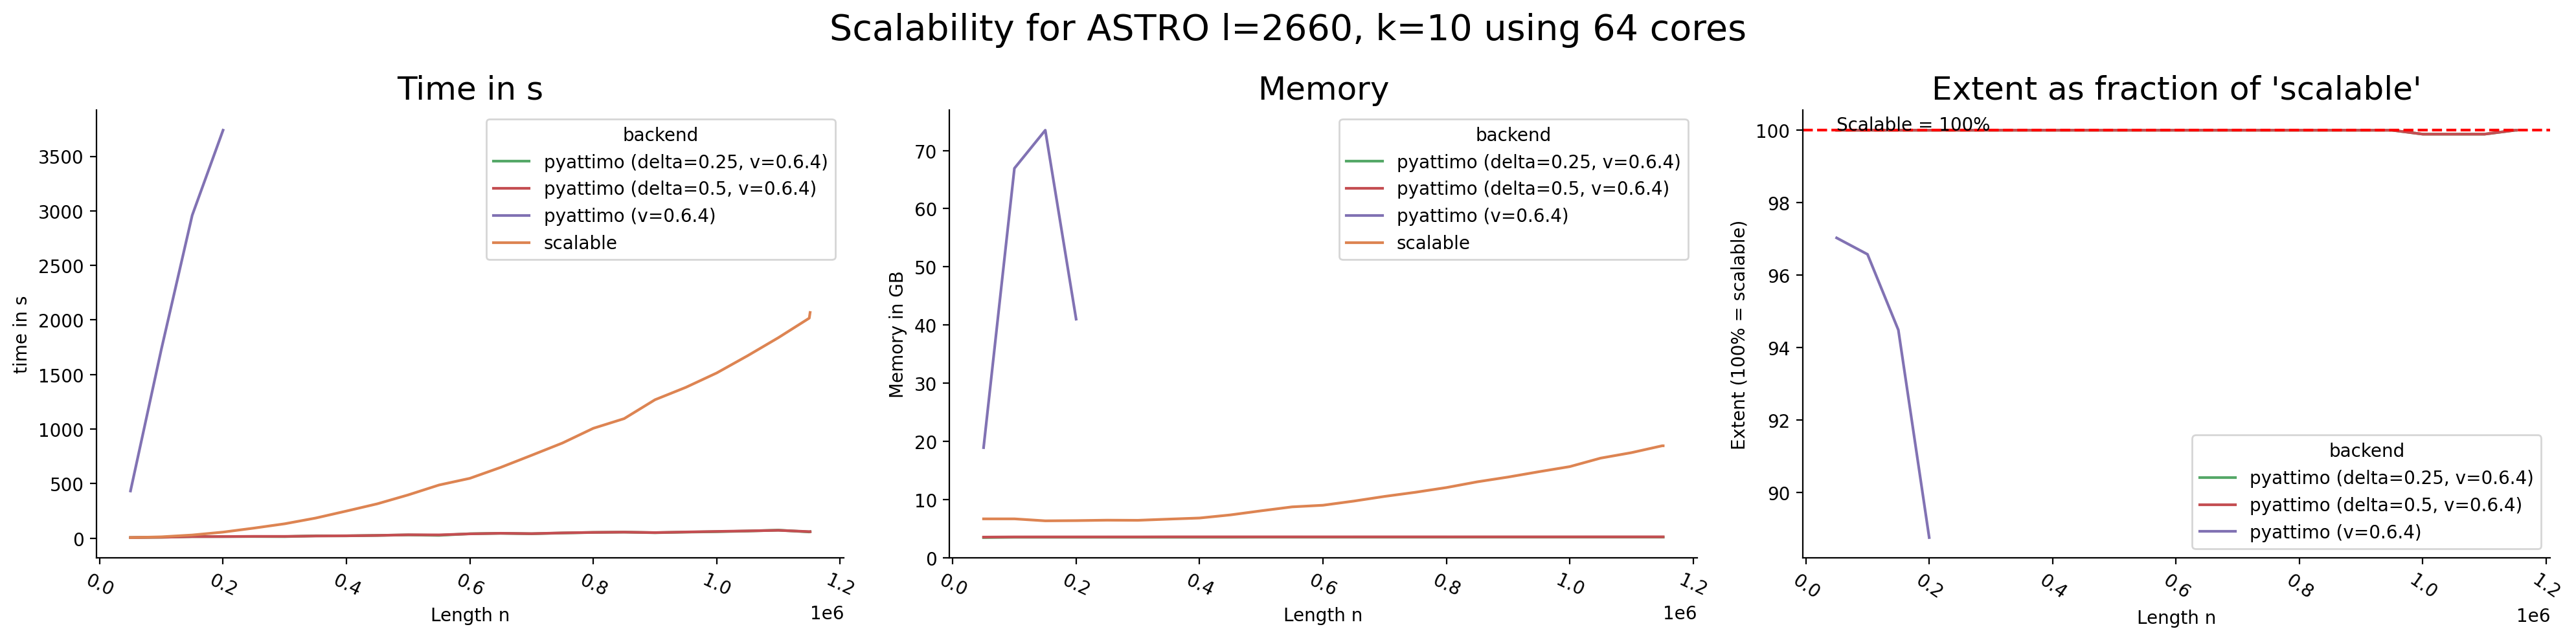

In [9]:
def read_astro():
    # return "ASTRO", pd.read_csv("../tests/results/scalability_n_ASTRO_2660_10.csv", index_col=0)

    filename = "scalability_n_ASTRO_2660_10"
    
    df = pd.read_csv(path + "default/" + filename + ".csv", index_col=0)
    for backend in ["delta_logs_v0.6.4"]:  # "delta_logs_v0.6.2", 
        df_delta_0_25 = pd.read_csv(path + backend + "/" + filename + "_delta_0.25.csv", index_col=0)
        df_delta_0_25["backend"] = df_delta_0_25["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_delta_0_50 = pd.read_csv(path + backend + "/" + filename + "_delta_0.5.csv", index_col=0)
        df_delta_0_50["backend"] = df_delta_0_50["backend"].astype(str)# + " " + backend.split("_")[-1]
        df_no_delta = pd.read_csv(path + backend + "/" + filename + ".csv", index_col=0)
        df_no_delta["backend"] = df_no_delta["backend"].astype(str)# + " " + backend.split("_")[-1]
        df = pd.concat([df, df_delta_0_25, df_delta_0_50, df_no_delta], ignore_index=False)

    return "ASTRO", df

ds_name, df = read_astro()
df = plot_df(df, ds_name, l=2660, k=10)

df_all = pd.concat([df_all, df], ignore_index=False)

In [10]:
# df_all.groupby(["dataset"])["extent"].mean()
# display(df_all)

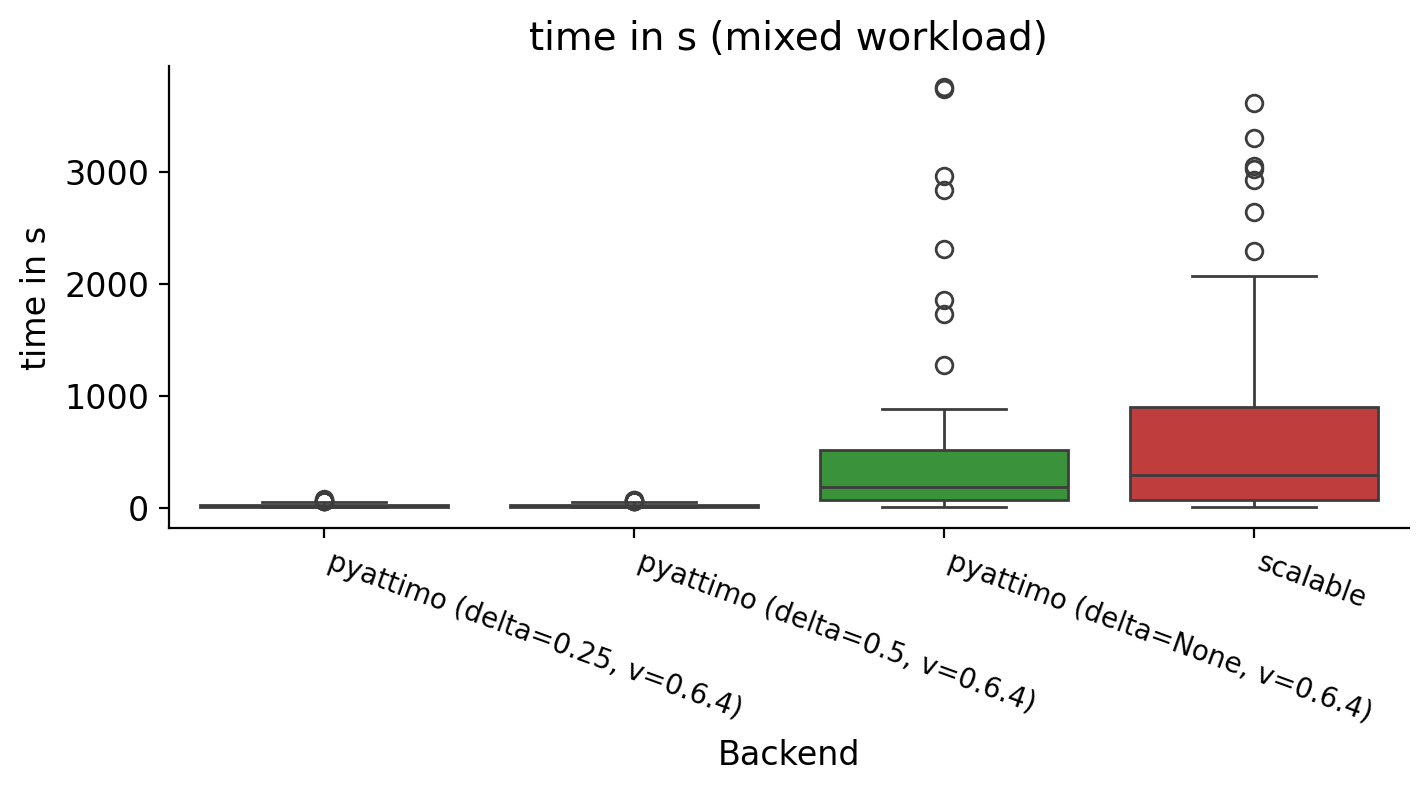

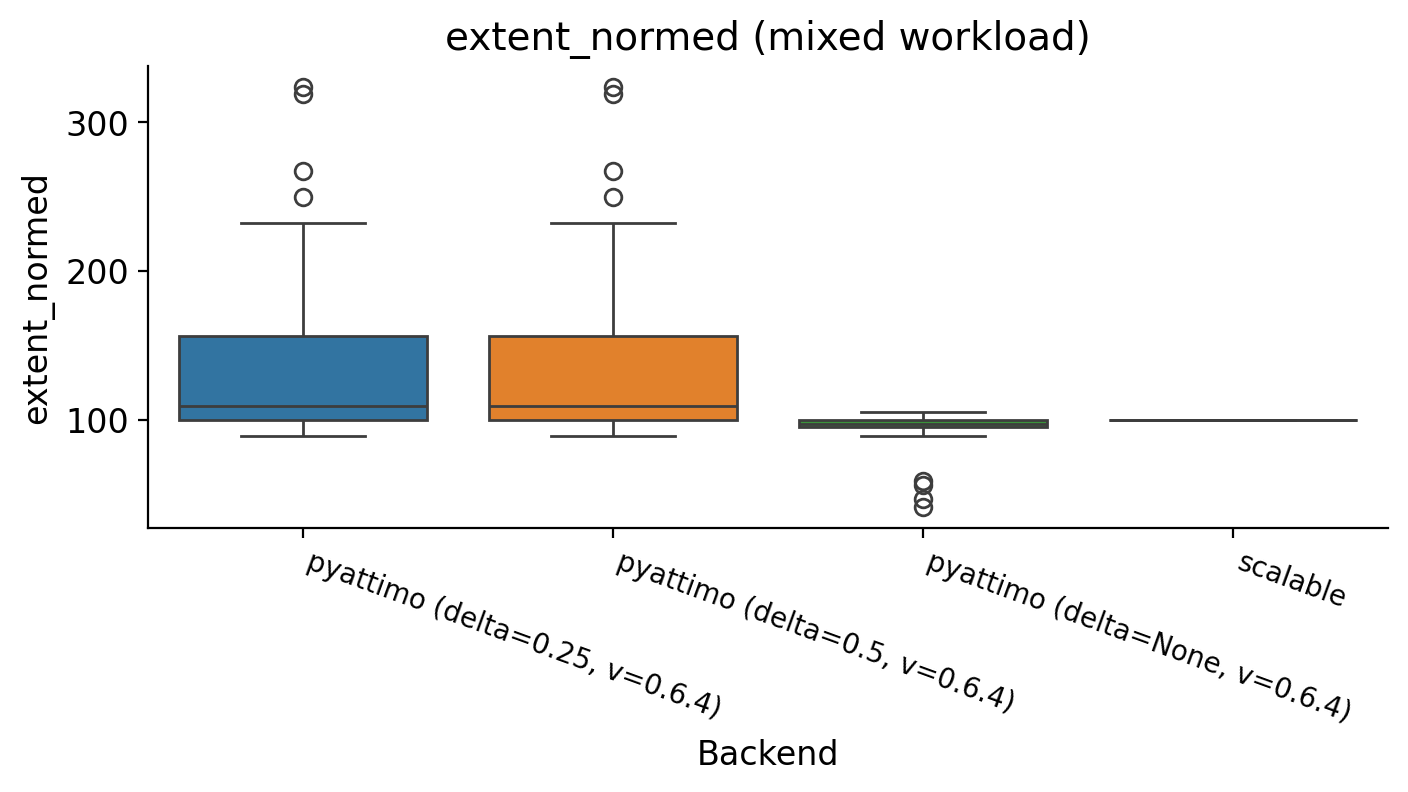

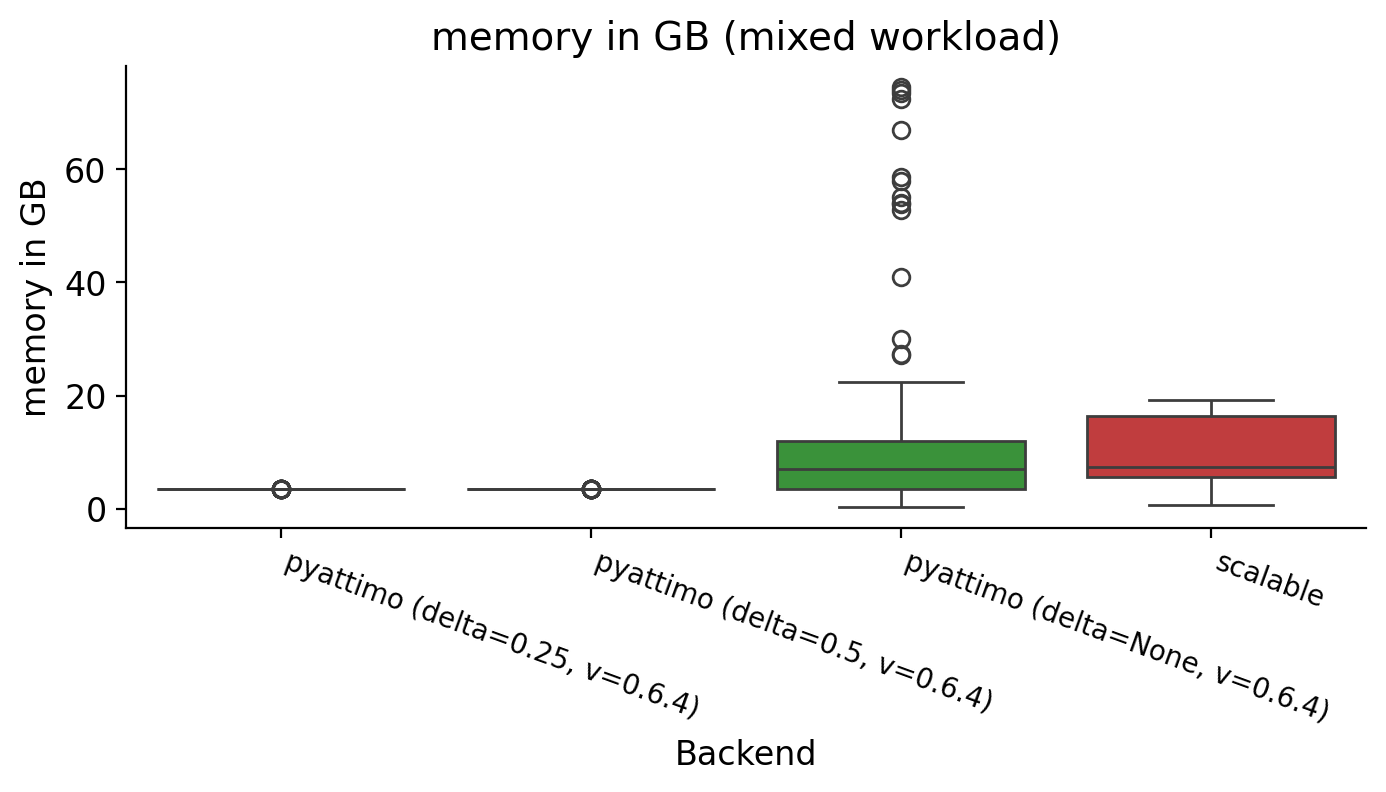

In [14]:
df_all["backend"] = df_all["backend"].str.replace("pyattimo (v=0.6.4)", "pyattimo (delta=None, v=0.6.4)")

with plt.style.context({
    'font.size': 16,          # Default font size
    'axes.titlesize': 14,     # Font size for axes titles
    'axes.labelsize': 12,     # Font size for x and y labels
    'xtick.labelsize': 12,    # Font size for x tick labels
    'ytick.labelsize': 12,    # Font size for y tick labels
    'legend.fontsize': 10,    # Font size for legend
    'figure.titlesize': 14    # Font size for figure title
}):    

    for i, column in enumerate(["time in s", "extent_normed", "memory in GB"]):  # "extent", 
        # plot_order = df_sub.groupby(["backend"]).mean(column).sort_values(by=column)
        # plot_order = df_sub.sort_values(by=column)
        
        fig, ax = plt.subplots(figsize=(8,3))
        
        sns.boxplot(x="backend", y=column, hue="backend", data=df_all, ax=ax)   # order=plot_order.index, 
        sns.despine()
        
        ax.set_title(f"{column} (mixed workload)")
        ax.set_xlabel("Backend")

        #if column != "extent_normed":
        #    ax.set_yscale('log')

        plt.xticks(rotation=-20, fontsize=10, ha='left')
        
        # legend = ax.legend() # removes the title
        # sns.move_legend(ax, "upper center", frameon=False, bbox_to_anchor=(.5, -0.35), ncol=4)
        # plt.tight_layout()
            
        plt.show()
    
    
